# Single Cell Sequencing: 


Uses exon data extracted from: zUMIs_output\expression\*.dgecounts.rds and gene data from: zUMIs_output\expression\*.gene_names.txt<br>
Performs data aggregation from all plates.<br>
Performs quality control.<br>
Performs filtering.<br>
Performs normalization.<br>
Exports pre-processed data to h5ad file for further analysis.<br>

In [54]:
# !pip install --quiet anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
import pyreadr
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import os 
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 louvain==0.8.1 pynndescent==0.5.10


In [56]:
rds_file_sample1 = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample1\sample1_R.rds'  # the file read and prepared in R
h5ad_file_sample1 = r'C:\Users\\SingleCellSequencing\scs_analysis\my_data\sample1\sample1_R.h5ad'  # the file that will be used for Melisas script

rds_file_sample2 = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample2\sample2_R.rds'  # the file read and prepared in R
h5ad_file_sample2 = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample2\sample2_R.h5ad'  # the file that will be used for Melisas script

rds_file_sample3 = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample3\sample3_R.rds'  # the file read and prepared in R
h5ad_file_sample3 = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample3\sample3_R.h5ad'  # the file that will be used for Melisas script


In [57]:
# Read the RDS file and convert to a DataFrame
rds_sample1 = pyreadr.read_r(rds_file_sample1)

rds_sample2 = pyreadr.read_r(rds_file_sample2)

rds_sample3 = pyreadr.read_r(rds_file_sample3)

In [58]:
# convert to dataframes (they are different sizes)
rds_sample1_df = rds_sample1[list(rds_sample1.keys())[0]]

rds_sample2_df = rds_sample2[list(rds_sample2.keys())[0]]

rds_sample3_df = rds_sample3[list(rds_sample3.keys())[0]]

In [59]:
# merge whole dataframe, so that all will have the same amount of genes
unified_df = pd.concat([rds_sample1_df,rds_sample2_df,rds_sample3_df],axis=1)
# replace all NaN values with zero counts
unified_df = unified_df.fillna(0)
unified_df

,AACCATCGGCAACTACCACT,AACCATCGGCAAGTTATCGG,AACCATCGGCCACAATCCAC,AACCATCGGCCACTAACCGG,AACCATCGGCCCGTTCGTAT,AACCATCGGCCGACGGTTGT,AACCATCGGCCGAGTCATTA,AACCATCGGCGAAGCTAGCC,AACCATCGGCGTAACGTCTA,AACCATCGGCTCCAATGCAA,...,TTGTAATGCGGACCTGAAGA,TTGTAATGCGGGTATGGTGA,TTGTAATGCGTCCACAGCCA,TTGTAATGCGTGAATAGAGG,TTGTAATGCGTGCTGTTGTT,TTGTAATGCGTGGAGTTACA,TTGTAATGCGTTACTGTCGT,TTGTAATGCGTTACTTACCG,TTGTAATGCGTTCACGTCAG,TTGTAATGCGTTCGCCACAC
rownames,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001.4,0.0,1.0,4.0,0.0,2.0,4.0,2.0,2.0,1.0,0.0,...,0.0,0.0,3.0,0.0,0.0,3.0,2.0,1.0,4.0,0.0
ENSMUSG00000000028.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000031.16,16.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000037.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000049.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERCC-00025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERCC-00071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERCC-00111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# split back to 3 original dataframes but same sizes now
total_barcodes_df1 = rds_sample1_df.shape[1]
total_barcodes_df2 = rds_sample2_df.shape[1]
total_barcodes_df3 = rds_sample3_df.shape[1]

rds_sample1_df = unified_df.iloc[:,0:total_barcodes_df1]
till_col = total_barcodes_df1+total_barcodes_df2
rds_sample2_df = unified_df.iloc[:,total_barcodes_df1:till_col]
from_col = till_col
till_col = from_col+total_barcodes_df3
rds_sample3_df = unified_df.iloc[:,from_col:till_col]
rds_sample1_df.shape[0],rds_sample2_df.shape[0],rds_sample3_df.shape[0]

(37241, 37241, 37241)

In [61]:
# transpose before creating anndata object, so that gene ids are columns and barcodes are rows
transposed_rds_sample1_df = rds_sample1_df.transpose()# Create an AnnData object
adata1 = ad.AnnData(
    X=transposed_rds_sample1_df.values,  # Your data as numpy array
    obs={'barcode': transposed_rds_sample1_df.index},
    var={'gene_id': transposed_rds_sample1_df.columns}  
)

transposed_rds_sample2_df = rds_sample2_df.transpose()# Create an AnnData object
adata2 = ad.AnnData(
    X=transposed_rds_sample2_df.values,  # Your data as numpy array
    obs={'barcode': transposed_rds_sample2_df.index},
    var={'gene_id': transposed_rds_sample2_df.columns}  
)

transposed_rds_sample3_df = rds_sample3_df.transpose()# Create an AnnData object
adata3 = ad.AnnData(
    X=transposed_rds_sample3_df.values,  # Your data as numpy array
    obs={'barcode': transposed_rds_sample3_df.index},
    var={'gene_id': transposed_rds_sample3_df.columns}  
)

In [62]:
adata1

AnnData object with n_obs × n_vars = 384 × 37241
    obs: 'barcode'
    var: 'gene_id'

In [63]:
# save h5ad files that are necessary for further Melisas pipeline
adata1.write(h5ad_file_sample1)
adata2.write(h5ad_file_sample2)
adata3.write(h5ad_file_sample3)

In [64]:
# define all paths for storing data
figure_path = r'C:\Users\SingleCellSequencing\scs_analysis\figures'

output_path  = r'C:\Users\SingleCellSequencing\scs_analysis\out'
campari_file = 'campari_scs_from_R.h5ad'
campari_file_all_genes = 'campari_scs_all_genes_from_R.h5ad'

# files with scs data
results_file_sample1 = h5ad_file_sample1  
results_file_sample2 = h5ad_file_sample2 
results_file_sample3 = h5ad_file_sample3  


# txt file with well barcodes. the text contains the cell barcode corresponding to each position in the plate
well_barcode_sample1 = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample1\SS3_22_291.well_barcodes.txt'
well_barcode_sample2 = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample2\SS3_23_049.well_barcodes.txt'
well_barcode_sample3 = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample3\SS3_23_127.well_barcodes.txt'

# upload excel with red and green flourecence from campari (has information about position in plate and fluorecence level)
florecence_1_file_path = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample1\well_1_data_base.csv'
florecence_2_file_path = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample2\well_2_data_base.csv'
florecence_3_file_path = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample3\well_3_data_base.csv'

# paths to files with a list of gene ids and matching gene names (they are not the same the same...)
genes1_path = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample1\SS3_22_291.gene_names.txt'
genes2_path = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample2\SS3_23_049.gene_names.txt'
genes3_path = r'C:\Users\SingleCellSequencing\scs_analysis\my_data\sample3\SS3_23_127.gene_names.txt'


In [65]:
# load adata file using adata library
sample1 = ad.read_h5ad(results_file_sample1)
sample2 = ad.read_h5ad(results_file_sample2)
sample3 = ad.read_h5ad(results_file_sample3)

# read gene ids and names
genes1 = pd.read_csv(genes1_path, delimiter = "\t")
genes2 =  pd.read_csv(genes2_path, delimiter = "\t")
genes3 =  pd.read_csv(genes3_path, delimiter = "\t")

# read fluorecence levels
flourecence1 = pd.read_csv(florecence_1_file_path)
flourecence2 = pd.read_csv(florecence_2_file_path)
flourecence3 = pd.read_csv(florecence_3_file_path)

# read barcodes in the same order as in the anndata object
barcodes1 = [el[0] for el in list(sample1.obs.values)]
barcodes2 = [el[0] for el in list(sample2.obs.values)]
barcodes3 = [el[0] for el in list(sample3.obs.values)]


# merge data base. Merge information about cell barcode and fluorecence 
#(using as common demonimator the position in the plate)
# barcode_list_sample1 = list(df_1_sample1['XC']) # from kept barcodes
well_df_sample1 = pd.read_csv(well_barcode_sample1, delimiter = "\t")
mergedRes1 = pd.merge(well_df_sample1 , flourecence1, on ='well_id')

# barcode_list_sample2 = list(df_1_sample2['XC'])
well_df_sample2 = pd.read_csv(well_barcode_sample2, delimiter = "\t")
mergedRes2 = pd.merge(well_df_sample2 , flourecence2, on ='well_id')

# barcode_list_sample3 = list(df_1_sample3['XC'])
well_df_sample3 = pd.read_csv(well_barcode_sample3, delimiter = "\t")
mergedRes3 = pd.merge(well_df_sample3 , flourecence3, on ='well_id')

In [66]:
# returns ordered well ids, stimulus and fluorescence from each sample
def barcode_check(barcode_list,mergedRes):

    well_id = np.zeros((len(barcode_list),))

    red_f = np.zeros((len(barcode_list),))
    green_f = np.zeros((len(barcode_list),))
    stimulus = np.zeros((len(barcode_list),))


    count = 0
    counter = 0
    for i in range(len(barcode_list)):
        x = barcode_list[i]
        index = barcode_list.index(x)
        if len(np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)):
            counter+=1
            position = np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)[0][0]
            stimulus[index] = mergedRes['stimulus'].where(mergedRes['bc_set'] == x)[position]
            red_f[index] = mergedRes['red_f'].where(mergedRes['bc_set'] == x)[position]
            green_f[index] = mergedRes['green_f'].where(mergedRes['bc_set'] == x)[position]
            well_id[index] = 1
            count +=1
    
    return well_id,stimulus,red_f,green_f

In [67]:
well_id1,stimulus_1,red_f1,green_f1 = barcode_check(barcodes1,mergedRes1)
well_id2,stimulus_2,red_f2,green_f2 = barcode_check(barcodes2,mergedRes2)
well_id3,stimulus_3,red_f3,green_f3 = barcode_check(barcodes3,mergedRes3)

In [68]:
### 
adata1 = sample1
adata2 = sample2
adata3 = sample3

### add campari information to adata structure
adata1.obs['stimulus'] = stimulus_1 
adata1.obs['red'] = red_f1
adata1.obs['green'] = green_f1
adata1.obs['well_id'] = well_id1

adata2.obs['stimulus'] = stimulus_2
adata2.obs['red'] = red_f2
adata2.obs['green'] = green_f2
adata2.obs['well_id'] = well_id2

adata3.obs['stimulus'] = stimulus_3
adata3.obs['red'] = red_f3
adata3.obs['green'] = green_f3
adata3.obs['well_id'] = well_id3

In [69]:
### data integration
adata_1 = adata1.concatenate(adata2, join='outer', batch_categories=['sample1', 'sample2'], index_unique='-')

adata = adata_1.concatenate(adata3, join='outer', batch_categories=['sample12', 'sample3'], index_unique='-')

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Number of cells:', adata.X.shape[0]) # len(adata.obs_names)
print('Number of genes:', adata.X.shape[1]) # len(adata.var_names)

Number of cells: 1152
Number of genes: 37241


c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [70]:
adata.var['gene_id'].values

array(['ENSMUSG00000000001.4', 'ENSMUSG00000000028.15',
       'ENSMUSG00000000031.16', ..., 'ERCC-00111', 'ERCC-00145',
       'ERCC-00162'], dtype=object)

In [71]:
# takes list of gene ids and list of dataframes with id2names, returns list of matched gene names
# gene ids come from all plates now and each plate has own file with gene names
def translate2gene_names(gene_ids,list_of_gene_files):
    cnt= 0
    gene_names = []
    for i,id in enumerate(gene_ids):
        gene = id
        for gene_list in list_of_gene_files:
            ids = gene_list["gene_id"].tolist()
            names = gene_list["gene_name"].tolist()
            if id in ids:
                idx = ids.index(id)
                gene = names[idx]
        # if after searching in all available gene files, id still not translated to name
        if gene == id:
            cnt+=1
        gene_names.append(gene)
    if cnt >0:
        print(f"missing {cnt} gene names")
    return gene_names

In [72]:
# translate gene ids to names and add to anndata
gene_names = translate2gene_names(adata.var["gene_id"].values,[genes1,genes2,genes3])

missing 32 gene names


In [73]:
# add gene names to anndata object
adata.var["gene_name"] = gene_names
adata.var.index = adata.var["gene_name"]

## QUALITY CONTROL

In [74]:
adata

AnnData object with n_obs × n_vars = 1152 × 37241
    obs: 'barcode', 'stimulus', 'red', 'green', 'well_id', 'batch'
    var: 'gene_id', 'gene_name'

In [75]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1)
x =  adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(x)
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

In [76]:
cnt = 0
for gene in adata.var["gene_name"].values:
    if gene.startswith('mt-'):
        cnt+=1
print(f"total mitochondrial: {cnt}")

total mitochondrial: 37


normalizing counts per cell


    finished (0:00:00)


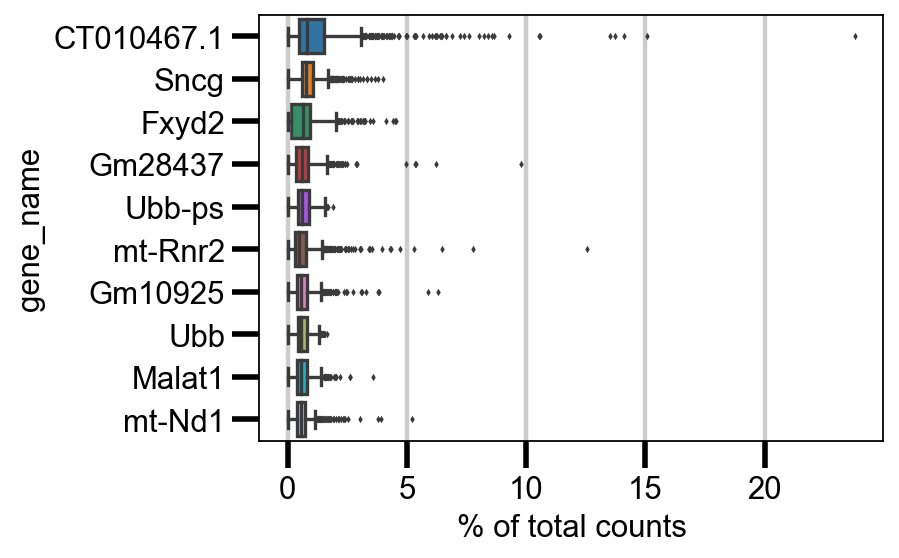

In [77]:
sc.pl.highest_expr_genes(adata, n_top=10, )

In [78]:
# Filter cells according to identified QC thresholds:
print('Total number of cells before: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_counts = 10000)
print('Total number of cells after: {:d}'.format(adata.n_obs))

Total number of cells before: 1152
filtered out 76 cells that have less than 10000 counts


Total number of cells after: 1076


c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [79]:
print('Number of cells before: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = 3000)
print('Total number of cells after: {:d}'.format(adata.n_obs))

Number of cells before: 1076
filtered out 1 cells that have less than 3000 genes expressed


Total number of cells after: 1075


In [80]:
print('Number of genes before: {:d}'.format(adata.n_vars))
sc.pp.filter_genes(adata, min_cells=5)
print('Number of genes after: {:d}'.format(adata.n_vars))

Number of genes before: 37241
filtered out 11251 genes that are detected in less than 5 cells
Number of genes after: 25990


c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [81]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


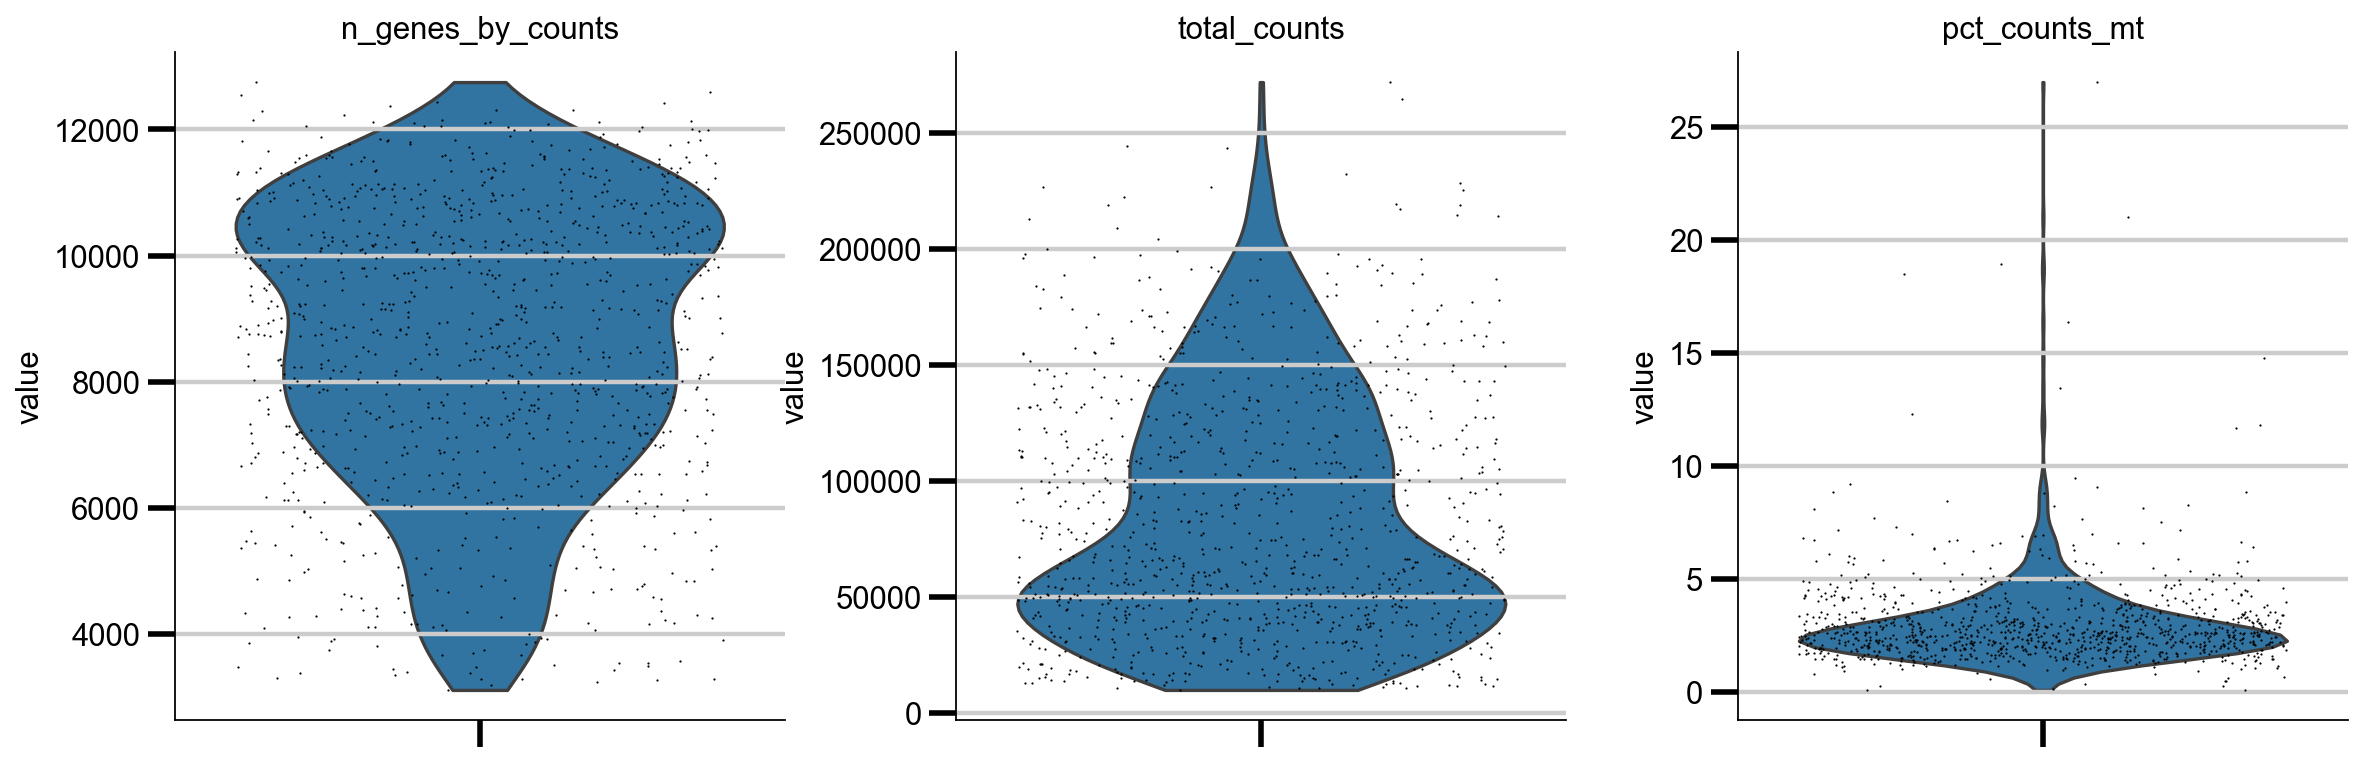

In [82]:
adata.var_names_make_unique()
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [83]:
# Do the filtering by slicing the AnnData object
print('Number of cells before: {:d}'.format(adata.n_obs))
# keep only below 5% mitochondrial
adata = adata[adata.obs.pct_counts_mt < 5, :]
print('Number of cells after: {:d}'.format(adata.n_obs))

Number of cells before: 1075
Number of cells after: 989


In [84]:
# save all genes before filtering highly variable
adata.write_h5ad(
    os.path.join(output_path, campari_file_all_genes),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

In [85]:
# Normalize and select highly variable genes
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=15000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 15000


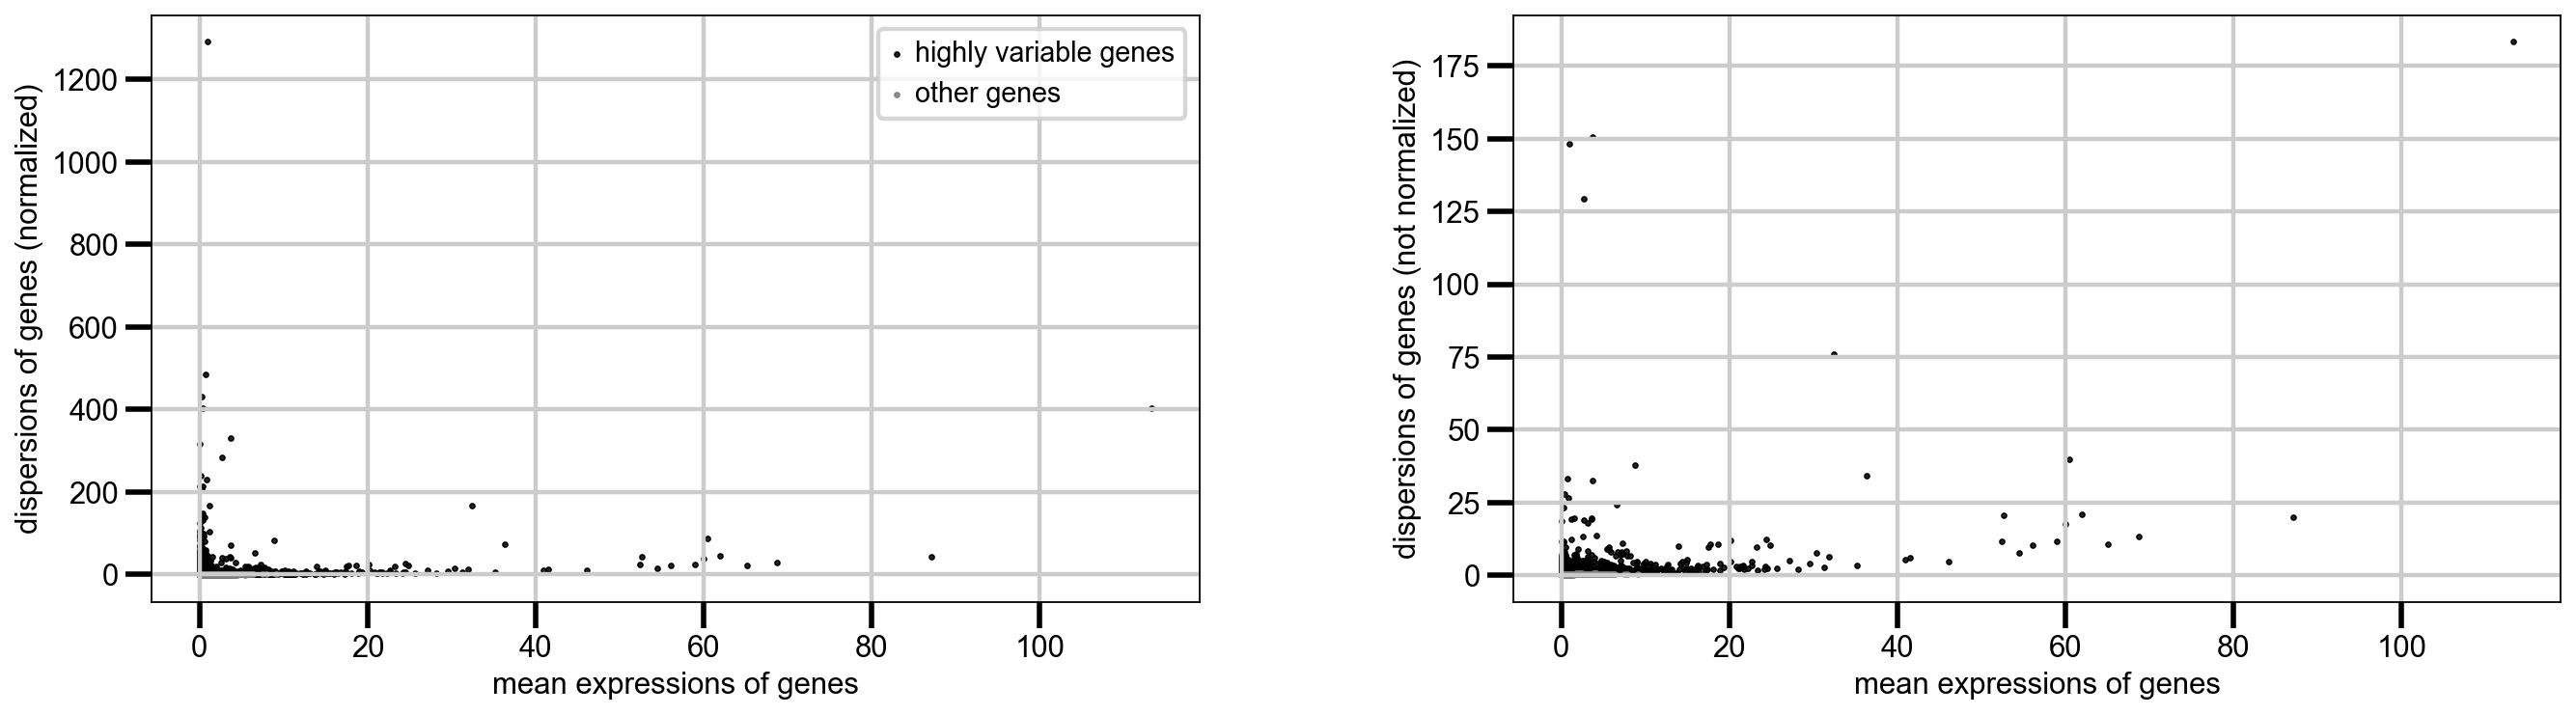

(989, 25990)


In [86]:
from matplotlib import rcParams

rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

print(adata.shape)

In [87]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:29)


In [88]:
# export normalized data
adata.write_h5ad(
    os.path.join(output_path,campari_file),
#    compression=hdf5plugin.FILTERS["zstd"],
#    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)